## **Data Preparing**

**Import Library and Load Data**
- Import Library ที่จำเป็น เช่น `torch`, `torchvision` `datasets` etc. 
- โหลดชุดข้อมูลจาก Hugging Face ชื่อ **plastic_detection_roboflow**

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from datasets import load_dataset
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

dataset = load_dataset("tukey/plastic_detection_roboflow", split="train")

print(dataset)

print(dataset[0]['qa'])

Dataset({
    features: ['image', 'qa'],
    num_rows: 22075
})
[{'question': 'are there HDPE Plastic in the image?', 'answer': 'yes'}, {'question': 'are there Single-Use-Plastic in the image?', 'answer': 'no'}]


In [2]:
unique_questions = set()

for item in dataset:  
    for qa in item['qa']: 
        unique_questions.add(qa['question'])

print(f"have {len(unique_questions)} different questions :")
for question in sorted(unique_questions):  
    print(question)

have 8 different questions :
are there HDPE Plastic in the image?
are there Multi-layer Plastic in the image?
are there PET Bottle in the image?
are there Single-Use-Plastic in the image?
are there Single-layer Plastic in the image?
are there Squeeze-Tube in the image?
are there UHT-Box in the image?
are there bottle-waste-bow-bag in the image?


**Labels Merge**
- แทนที่คำถาม Non-Recyclable ใน data
    - ใช้ฟังก์ชัน `replace_non_recyclable` ค้นหาคำที่เกี่ยวข้องกับพลาสติก Non-Recyclable (`Single-Use-Plastic`, `Multi-layer Plastic`, `bottle-waste-bow-bag`, และ `UHT-Box`) ในฟิลด์ `qa` 
    - จากนั้นแทนที่คำเหล่านี้ด้วยคำว่า `Non-Recyclable`

- ลบข้อมูลซ้ำใน Data    
    - ใช้ฟังก์ชัน `remove_duplicate_non_recyclable` ลบคำถาม `Non-Recyclable` ที่มีคำตอบ `yes` โดยคงไว้เพียงคำถามเดียวใน `rows`

In [22]:
# replace Non-Recyclable
def replace_non_recyclable(example):
    replace_terms = [
        "Single-Use-Plastic", 
        "Multi-layer Plastic", 
        "bottle-waste-bow-bag", 
        "UHT-Box"
    ]
    
    for qa in example['qa']:
        for term in replace_terms:
            if term in qa['question']:
                qa['question'] = qa['question'].replace(term, 'Non-Recyclable')
                
    return example

# delete duplicate Non-Recyclable == yes
def remove_duplicate_non_recyclable(example):
    seen = set()
    unique_qa = []
    for qa in example['qa']:
        if qa['question'] == 'are there Non-Recyclable in the image?' and qa['answer'] == 'yes':
            # if Non-Recyclable duplicate add just one
            if (qa['question'], qa['answer']) not in seen:
                seen.add((qa['question'], qa['answer']))
                unique_qa.append(qa)
        else:
            unique_qa.append(qa)
    example['qa'] = unique_qa
    return example

# map
dataset = dataset.map(replace_non_recyclable)
dataset = dataset.map(remove_duplicate_non_recyclable)

Map:   0%|          | 0/22075 [00:00<?, ? examples/s]

Map:   0%|          | 0/22075 [00:00<?, ? examples/s]

In [23]:
print(dataset[281]['qa'])

[{'question': 'are there Non-Recyclable in the image?', 'answer': 'yes'}, {'question': 'are there Single-layer Plastic in the image?', 'answer': 'yes'}, {'question': 'are there HDPE Plastic in the image?', 'answer': 'no'}, {'question': 'are there Non-Recyclable in the image?', 'answer': 'no'}, {'question': 'are there Squeeze-Tube in the image?', 'answer': 'no'}]


In [24]:
unique_questions = set()

for item in dataset:  
    for qa in item['qa']: 
        unique_questions.add(qa['question'])

print(f"have {len(unique_questions)} different questions :")
for question in sorted(unique_questions):  
    print(question)

have 5 different questions :
are there HDPE Plastic in the image?
are there Non-Recyclable in the image?
are there PET Bottle in the image?
are there Single-layer Plastic in the image?
are there Squeeze-Tube in the image?


**Custom Dataset**
- สร้างคลาส `PlasticDataset` เพื่อ:
  - แปลงข้อมูลภาพเป็น Tensor
  - สร้าง multi-label vector จากคำถามในคอลัมน์ `qa`

In [25]:
# Custom Dataset
class PlasticDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        # plastic type 
        self.labels = [
            "PET Bottle",
            "HDPE Plastic",
            "Single layer Plastic",
            "Squeeze Tube",
            "Non Recyclable"
        ]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Check: URL or PIL Image
        img_data = self.dataset[idx]['image']

        # load img
        if isinstance(img_data, str):  # if URL
            response = requests.get(img_data)
            img = Image.open(BytesIO(response.content)).convert('RGB')
        else:  # if PIL Image
            img = img_data.convert('RGB')

        # transform img
        if self.transform:
            img = self.transform(img)

        # create multi-label vector
        label = torch.zeros(len(self.labels))
        for qa in self.dataset[idx]['qa']:
            # matching question : self.labels
            clean_question = (
                qa['question']
                .replace("are there ", "")
                .replace(" in the image?", "")
                .replace("-", " ")
                .strip()
            )

            if qa['answer'] == 'yes' and clean_question in self.labels:
                label[self.labels.index(clean_question)] = 1
        
        return img, label

## **Data Processing and Splitting**

**Edit and Split Data**
- เพิ่ม **Data Augmentation** เพื่อปรับแต่งข้อมูลภาพ
- แบ่งข้อมูลเป็น **Train(70%), Validation(15%), Test(15%)**
- สร้าง **DataLoader** สำหรับโหลดข้อมูลใน **batch**

In [26]:
# Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(10),   
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# split: train, validation, test
train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - valid_size
train_split, valid_split, test_split = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

# create Datasets
train_data = PlasticDataset(train_split, transform=transform)
valid_data = PlasticDataset(valid_split, transform=transform)
test_data = PlasticDataset(test_split, transform=transform)

# create DataLoadersS
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## **Model Configuration and Training**

**Model Setting**
- โหลดโมเดล ResNet-50 พร้อมค่าที่ฝึกมาก่อน (Pretrained)
- ปรับ Fully Connected Layer ให้ตรงกับจำนวนคลาสในชุดข้อมูล
- ตั้งค่า Loss Function (`BCEWithLogitsLoss`) และ Optimizer (`Adam`)

In [32]:
# Load Model: Pretrained ResNet-50
model = models.resnet50(pretrained=True)

# change Fully Connected Layer
model.fc = torch.nn.Linear(model.fc.in_features, len(train_data.labels))

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss Function
criterion = torch.nn.BCEWithLogitsLoss()  # for Multi-label Classification

# optimizer: learning rate, (Regularization Techniques)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

**Training Model**
- วนลูปการฝึกโมเดล:
  - อัพเดตน้ำหนักด้วยการ backward
  - คำนวณค่า Loss สำหรับ Train และ Validation
  - ใช้ Early Stopping หาก Validation Loss ไม่ลดลงใน 3 epoch

In [33]:
# Train

# early stopping
patience = 4  
best_valid_loss = float('inf')
epochs_without_improvement = 0

# setting
num_epochs = 15
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation Phase
    model.eval()
    running_valid_loss = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_valid_loss += loss.item()

    avg_valid_loss = running_valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}")

    # check early stopping
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        epochs_without_improvement = 0  
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break  

Epoch 1/15, Train Loss: 0.2430, Valid Loss: 0.1906
Epoch 2/15, Train Loss: 0.1846, Valid Loss: 0.1751
Epoch 3/15, Train Loss: 0.1654, Valid Loss: 0.1564
Epoch 4/15, Train Loss: 0.1558, Valid Loss: 0.1117
Epoch 5/15, Train Loss: 0.1463, Valid Loss: 0.1046
Epoch 6/15, Train Loss: 0.1342, Valid Loss: 0.1103
Epoch 7/15, Train Loss: 0.1282, Valid Loss: 0.1100
Epoch 8/15, Train Loss: 0.1189, Valid Loss: 0.1094
Epoch 9/15, Train Loss: 0.1119, Valid Loss: 0.0975
Epoch 10/15, Train Loss: 0.1073, Valid Loss: 0.1041
Epoch 11/15, Train Loss: 0.1039, Valid Loss: 0.0971
Epoch 12/15, Train Loss: 0.1010, Valid Loss: 0.1182
Epoch 13/15, Train Loss: 0.0961, Valid Loss: 0.0795
Epoch 14/15, Train Loss: 0.0941, Valid Loss: 0.0849
Epoch 15/15, Train Loss: 0.0898, Valid Loss: 0.1003


## **Evaluation**

**Train loss VS Validation loss**
- สร้างกราฟแสดง Train Loss และ Validation Loss ในแต่ละ Epoch
- ใช้เพื่อประเมินการ overfitting หรือ underfitting

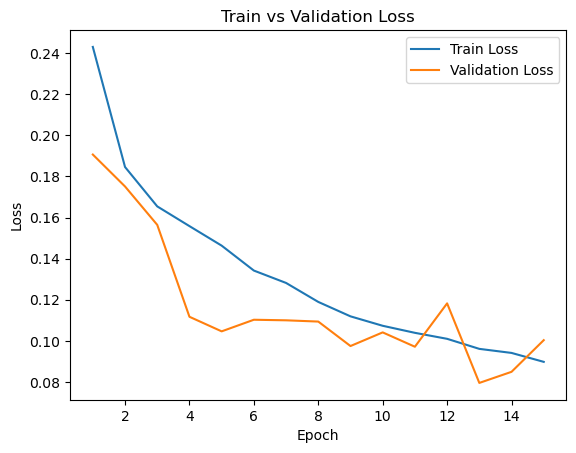

In [34]:
# Plot Loss

epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss')
plt.show()

**Testing Model Performance**
- ทดสอบโมเดลในชุดข้อมูลทดสอบ
- คำนวณค่า Accuracy, Precision, Recall และ F1 Score ในรูปแบบ Micro, Macro และ Weighted

In [35]:
#test
model.eval()
test_loss = 0.0
all_predictions = []
all_labels = []
correct_predictions = 0
total_samples = 0
accuracy = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Collect Data for Calculate Metrics 
        predicted_labels = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
        all_predictions.append(predicted_labels)
        all_labels.append(labels.cpu().numpy())

        # คำนวณจำนวนการทำนายที่ถูกต้อง
        correct_predictions += (predicted_labels == labels).all(dim=1).sum().item()
        total_samples += labels.size(0)

    avg_test_loss = test_loss / len(test_loader)
    accuracy = correct_predictions / total_samples
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

# รวมผลลัพธ์ทั้งหมด
all_predictions = np.vstack(all_predictions)
all_labels = np.vstack(all_labels)

# Precision, Recall, F1 Score
micro_f1 = f1_score(all_labels, all_predictions, average='micro')
macro_f1 = f1_score(all_labels, all_predictions, average='macro')
weighted_f1 = f1_score(all_labels, all_predictions, average='weighted')

micro_precision = precision_score(all_labels, all_predictions, average='micro')
macro_precision = precision_score(all_labels, all_predictions, average='macro')
weighted_precision = precision_score(all_labels, all_predictions, average='weighted')

micro_recall = recall_score(all_labels, all_predictions, average='micro')
macro_recall = recall_score(all_labels, all_predictions, average='macro')
weighted_recall = recall_score(all_labels, all_predictions, average='weighted')

# Result Metrics
print(f"Precision (Micro): {micro_precision:.4f}")
print(f"Recall (Micro): {micro_recall:.4f}")
print(f"F1 Score (Micro): {micro_f1:.4f}")

print(f"Precision (Macro): {macro_precision:.4f}")
print(f"Recall (Macro): {macro_recall:.4f}")
print(f"F1 Score (Macro): {macro_f1:.4f}")

print(f"Precision (Weighted): {weighted_precision:.4f}")
print(f"Recall (Weighted): {weighted_recall:.4f}")
print(f"F1 Score (Weighted): {weighted_f1:.4f}")

Test Loss: 0.1056
Test Accuracy: 86.32%
Precision (Micro): 0.9166
Recall (Micro): 0.9001
F1 Score (Micro): 0.9083
Precision (Macro): 0.9261
Recall (Macro): 0.8737
F1 Score (Macro): 0.8949
Precision (Weighted): 0.9230
Recall (Weighted): 0.9001
F1 Score (Weighted): 0.9081


## **Prediction Visualize**

**Predict Result**
- ใช้ฟังก์ชัน `show_prediction` เพื่อ:
  - แสดงภาพจากชุดข้อมูลทดสอบ
  - แสดงผลคำทำนายของโมเดลและค่าจริง (Ground Truth)
  - ช่วยให้เข้าใจว่าโมเดลมองเห็นอะไรในภาพ

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7582842..2.64].


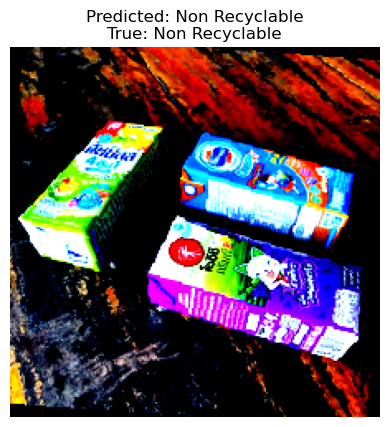

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..2.0996952].


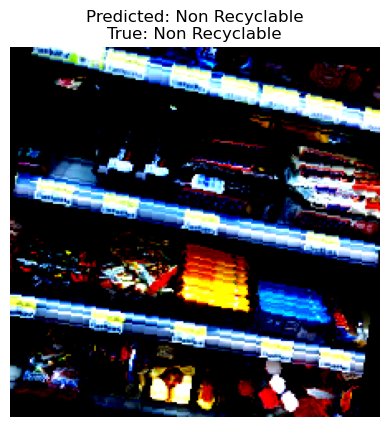

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.843908..2.64].


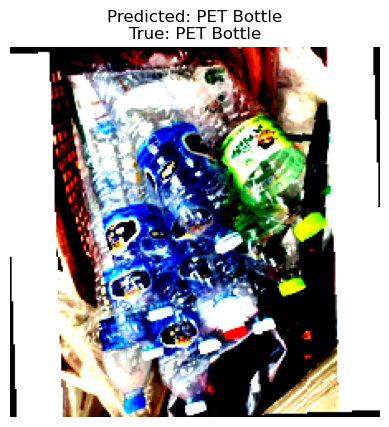

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


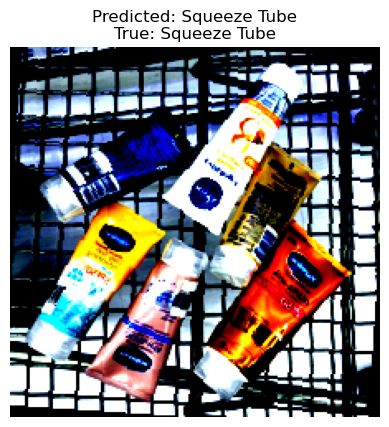

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781574..1.3328106].


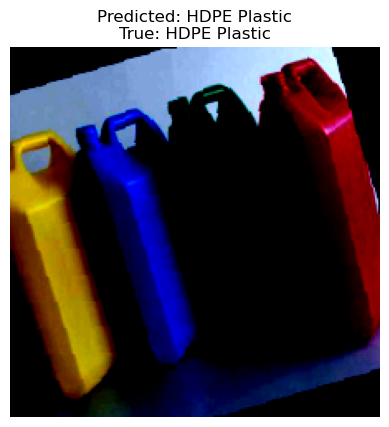

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].


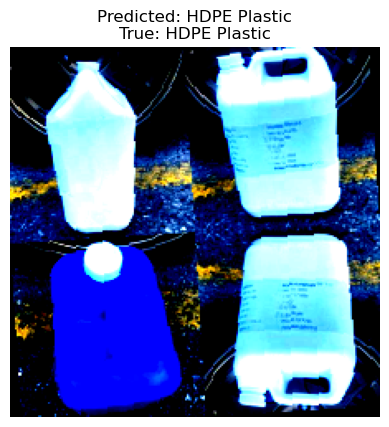

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..1.8208281].


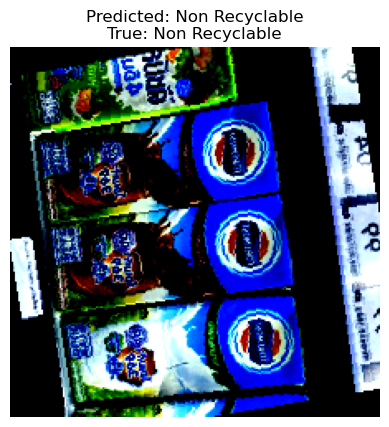

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3301654..1.8556864].


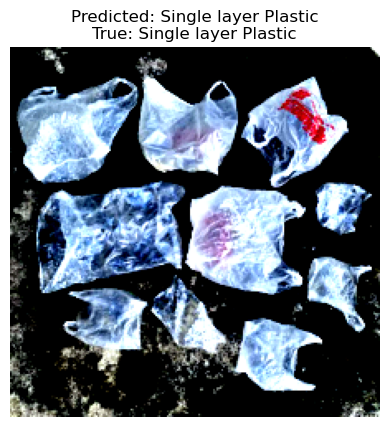

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..2.535425].


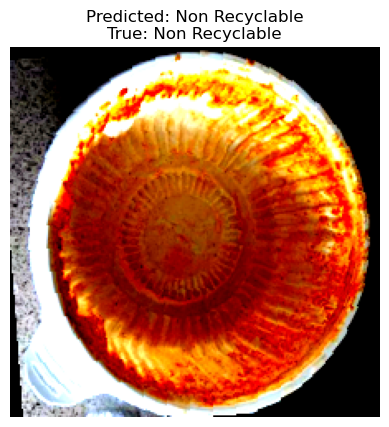

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0996952].


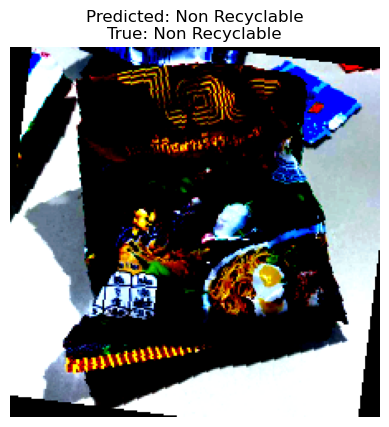

In [38]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def show_prediction(image, true_labels, model, labels):
    model.eval() 

    # ทำนาย
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)  # batch (1)
        output = model(image)
        predictions = torch.sigmoid(output).squeeze()  # ใช้ sigmoid เพื่อแปลงออกเป็นค่า 0-1 สำหรับ multi-label
        predicted_labels = predictions > 0.5  # ถ้าค่ามากกว่า 0.5 ให้ถือว่าเป็น 'yes'

  
    plt.imshow(np.array(image[0].cpu().permute(1, 2, 0)))  # Tensor to numpy array
    plt.axis('off') 

  
    predicted_classes = [labels[i] for i in range(len(labels)) if predicted_labels[i]]
    true_classes = [labels[i] for i in range(len(labels)) if true_labels[i]]

   
    plt.title(f'Predicted: {", ".join(predicted_classes)}\nTrue: {", ".join(true_classes)}')

    plt.show()

start_idx = 20
end_idx = 30

for idx in range(start_idx, end_idx):  
    image, true_labels = test_data[idx] 
    show_prediction(image, true_labels, model, train_data.labels) 